### Problem 1 : Data Science Challenge
- Goal: Predictive modeling and data visualization.

- Task:

    - Visualize the relation between features (you can design your own new features based on the given data)
    - Develop an ML model which, given the name of a director, predicts the release year of his next movie along with its probable genres
- Output: A GitHub repository with code, report or presentation that includes insights, methodologies, and conclusions.

- Evaluation: Accuracy of predictions, creativity in approach, clarity of presentation, and depth of insights.

- Data: Movie Metadata (./data/p1_movie_metadata.csv)

# IMPORTS

In [1]:
import os, csv 
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime


In [2]:
# DATA PATH 
movie_csv_path = "../selection-problems/data/p1_movie_metadata.csv"

In [3]:
# READING AND PUTTING THE CSV DATA IN df
df = pd.read_csv(movie_csv_path)
df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

# PRE-PROCESSING

### HELPER FUNCTIONS

In [10]:
def process_text(df_obj, columns=[]):
    category_label_map = {}
    for column in columns:
        print(column)
        unique_categories = sorted(df_obj[column].unique())
               
        _category_label_map = {category: i for i, category in enumerate(unique_categories)}

        # Replace 'MISSING' with a placeholder value (-1)
        if 'MISSING' in _category_label_map:
            _category_label_map['MISSING'] = -1
            # unique_categories.append(-1)
        category_label_map[column] = _category_label_map
        df_obj[f'{column}_label'] = df_obj[column].map(category_label_map[column])

        # df.drop(columns=[column], inplace=True) # WE CAN DROP THE COLUMN IF WE WANT
    
    return df_obj, category_label_map

def process_genre(df, genre_column='genres'):
    # Split the 'genre' column into separate columns
    genres = df[genre_column].str.get_dummies(sep='|')

    # Initialize new columns for each genre with 0 by default
    for genre in genres.columns:
        df[genre] = 0

    # Set values to 1 for each genre column if the movie belongs to that genre
    new_columns = []
    for index, row in df.iterrows():
        for genre in row[genre_column].split('|'):
            df.at[index, genre] = 1
            new_columns.append(genre)

    return df, sorted(list(set(new_columns)))


REMOVING NOT SO NECESSARY INFORMATION

In [5]:
df = df.drop(['movie_title', 'movie_imdb_link', 'plot_keywords'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  num_voted_users            5043 non-null   int64  
 12  cast_total_facebook_likes  5043 non-null   int64  
 13  actor_3_name               5020 non-null   objec

CHECKING FOR NaN

In [6]:
# CHECKING WHICH COLUMNS HAVE NaN OR NULL VALUES
nan_columns = df.columns[df.isnull().any()]
nan_columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'actor_3_name',
       'facenumber_in_poster', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'aspect_ratio'],
      dtype='object')

In [7]:
# REMOVING ROWS WHICH HAVE NaN VALUES
df = df.dropna()

In [11]:
nan_columns = df.columns[df.isnull().any()]
nan_columns

Index([], dtype='object')

In [12]:
# SEPARATING GENRES, PERMORING ONE-HOT ENCODING
df, new_genre_columns = process_genre(df, genre_column='genres')

In [13]:
new_genre_columns

['Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western']

##### CHANGING STRING DATA TO NUMBERS

In [14]:
# FINDING COLUMNS WHICH CONTIAN STING VALUES
string_columns = df.select_dtypes(include=['object']).columns
string_columns

Index(['color', 'director_name', 'actor_2_name', 'genres', 'actor_1_name',
       'actor_3_name', 'language', 'country', 'content_rating'],
      dtype='object')

In [15]:
# PROCESSING COLUMNS WITH STRING VALUES, 
# DOING ONE-HOT ENCODING AND CHANGING THOSE TO NUMBERIC VALUES FOR FURTHER PROCESSING
df, processed_labels = process_text(df, string_columns)

color
director_name
actor_2_name
genres
actor_1_name
actor_3_name
language
country
content_rating


In [16]:
# THE CHANGED VALUES, 
# KEEPING A COPY OF WHAT WAS CHANGED TO WHAT DURING ONE-HOT ENCODING
processed_labels

{'color': {' Black and White': 0, 'Color': 1},
 'director_name': {'Aaron Schneider': 0,
  'Aaron Seltzer': 1,
  'Abel Ferrara': 2,
  'Adam Goldberg': 3,
  'Adam Marcus': 4,
  'Adam McKay': 5,
  'Adam Rapp': 6,
  'Adam Rifkin': 7,
  'Adam Shankman': 8,
  'Adrian Lyne': 9,
  'Adrienne Shelly': 10,
  'Agnieszka Holland': 11,
  'Agnieszka Wojtowicz-Vosloo': 12,
  'Aki Kaurismäki': 13,
  'Akira Kurosawa': 14,
  'Akiva Goldsman': 15,
  'Akiva Schaffer': 16,
  'Alan Cohn': 17,
  'Alan J. Pakula': 18,
  'Alan Metter': 19,
  'Alan Parker': 20,
  'Alan Poul': 21,
  'Alan Rudolph': 22,
  'Alan Shapiro': 23,
  'Alan Taylor': 24,
  'Albert Brooks': 25,
  'Albert Hughes': 26,
  'Alejandro Agresti': 27,
  'Alejandro Amenábar': 28,
  'Alejandro G. Iñárritu': 29,
  'Alejandro Monteverde': 30,
  'Alessandro Carloni': 31,
  'Alex Craig Mann': 32,
  'Alex Garland': 33,
  'Alex Gibney': 34,
  'Alex Kendrick': 35,
  'Alex Proyas': 36,
  'Alex Rivera': 37,
  'Alex Smith': 38,
  'Alex Zamm': 39,
  'Alexander 

In [17]:
# FINAL DATASET WITH CHANGED VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 0 to 5042
Data columns (total 56 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      3769 non-null   object 
 1   director_name              3769 non-null   object 
 2   num_critic_for_reviews     3769 non-null   float64
 3   duration                   3769 non-null   float64
 4   director_facebook_likes    3769 non-null   float64
 5   actor_3_facebook_likes     3769 non-null   float64
 6   actor_2_name               3769 non-null   object 
 7   actor_1_facebook_likes     3769 non-null   float64
 8   gross                      3769 non-null   float64
 9   genres                     3769 non-null   object 
 10  actor_1_name               3769 non-null   object 
 11  num_voted_users            3769 non-null   int64  
 12  cast_total_facebook_likes  3769 non-null   int64  
 13  actor_3_name               3769 non-null   object 
 1

##### ADDING EXTRA INFORMATION IN OUT DATAFRAME FOR MAKING MODEL

In [18]:
df['title_year_DateStamp'] = pd.to_datetime(df['title_year'], format='%Y') # CONVERT 'title_year' COLUMN TO datetime FORMAT WHICH WILL BE USED IN COMING CALCULATION

df.sort_values(by=['director_name_label', 'title_year'], inplace=True) # SORTING THE DATA ACCORDING TO 'director_name_label' AND 'title_year'

df['time_since_last_release'] = df.groupby('director_name_label')['title_year_DateStamp'].diff().dt.days//365 # CALCULATING THE TIME DIFFERENCE BETWEEN THE MOVIE RELEASE FOR EACH DIRECTOR

# THERE WERE SOME DIRECTORS WHO HAVE ONLY ONE MOVIE,
# SO AFTER THE PREVIOUS STEP THERE WHERE NaN VALUES, AS DIFFERENCE BETWEEN ONE NUMBER AND NOTHING IS ABSURD.
# SO WE ADDED THE DIFFERENCE OF CURRENT YEAR - PREVIOUS MOVIE YEAR IN PLACE OF NaN VALUES.
current_year = datetime.now().year
df['time_since_last_release'].fillna(current_year - df['title_year_DateStamp'].dt.year, inplace=True) 

df['number_of_movies'] = df.groupby('director_name_label').cumcount() + 1 # TOTAL MOVIES RELAEASED BY EACH DIRECTOR

df['release_frequency'] = df.groupby('director_name_label')['time_since_last_release'].transform('mean') # CALCULATING THE AVERAGE MOVIE RELEASE FREQUENCY OF EACH DIRECTOR

df['collaboration'] = df[['actor_1_name_label', 'actor_2_name_label', 'actor_2_name_label']].count(axis=1) # CHECKING THE NUMBER OF ACTORS IN THE MOVIE

df['collaboration_likes'] = df[['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes']].sum(axis=1) # CHECKING TOTAL THE FACEBOOK LIKES OF ACTORS 

# df['success'] = (df['gross'] - df['budget'])
df['success'] = (df['gross'] - df['budget'] > 0).astype(int) # CHECKING IF THE MOVIES WAS SUCCESSFUL OR NOT


In [19]:
# DATA STRUCTURE WITH ADDED FEATURES
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   color                      3769 non-null   object        
 1   director_name              3769 non-null   object        
 2   num_critic_for_reviews     3769 non-null   float64       
 3   duration                   3769 non-null   float64       
 4   director_facebook_likes    3769 non-null   float64       
 5   actor_3_facebook_likes     3769 non-null   float64       
 6   actor_2_name               3769 non-null   object        
 7   actor_1_facebook_likes     3769 non-null   float64       
 8   gross                      3769 non-null   float64       
 9   genres                     3769 non-null   object        
 10  actor_1_name               3769 non-null   object        
 11  num_voted_users            3769 non-null   int64         
 12  cast_tot

In [20]:
# SELECTING RELEVANT FEATURES
features = ['director_name_label', 'director_facebook_likes','time_since_last_release', 'release_frequency', 'cast_total_facebook_likes', 'color_label', 'gross', 'success', 'movie_facebook_likes', 'content_rating_label']
target = 'title_year'
data = df[features + [target]].copy()

# VISUALIZATION

In [21]:
# LIBRARIES FOR VISUALIZATION

import seaborn as sns
import matplotlib.pyplot as plt


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   color                      3769 non-null   object        
 1   director_name              3769 non-null   object        
 2   num_critic_for_reviews     3769 non-null   float64       
 3   duration                   3769 non-null   float64       
 4   director_facebook_likes    3769 non-null   float64       
 5   actor_3_facebook_likes     3769 non-null   float64       
 6   actor_2_name               3769 non-null   object        
 7   actor_1_facebook_likes     3769 non-null   float64       
 8   gross                      3769 non-null   float64       
 9   genres                     3769 non-null   object        
 10  actor_1_name               3769 non-null   object        
 11  num_voted_users            3769 non-null   int64         
 12  cast_tot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Number of Movies released vs Year')

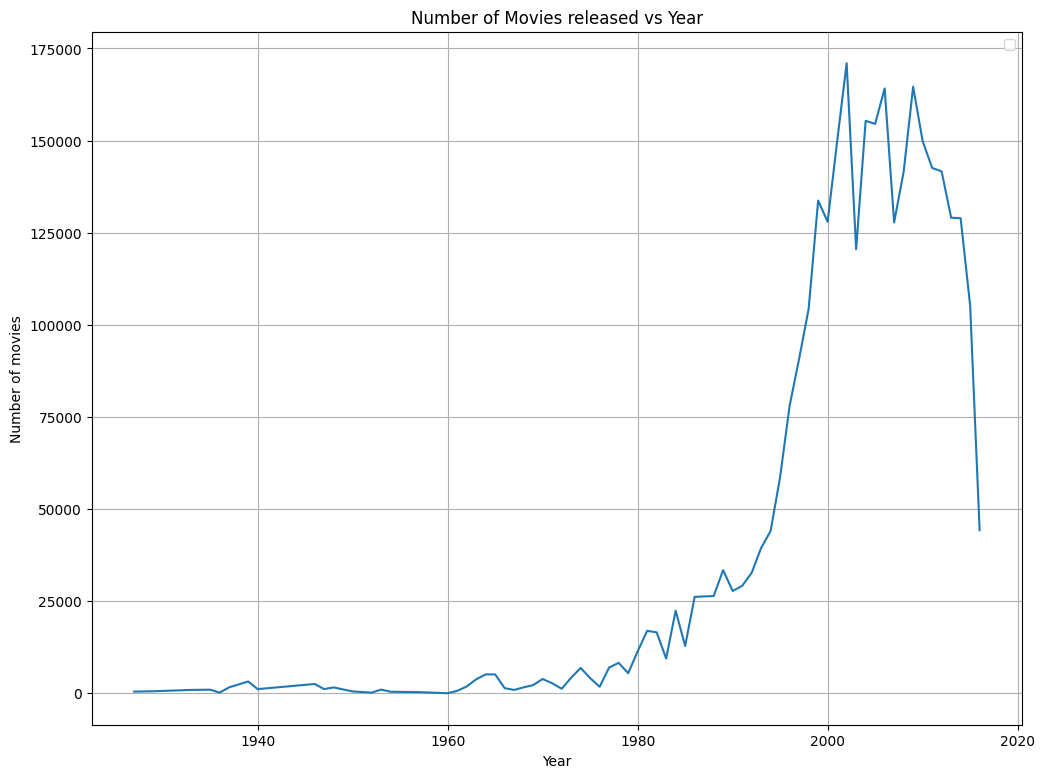

In [26]:
director_grouped = (df[['title_year', 'director_name_label']].groupby('title_year').sum())['director_name_label']

plt.figure(figsize=(12, 9))

plt.plot(sorted(df['title_year'].unique()), director_grouped)
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.legend()
plt.grid()
plt.title("Number of Movies released vs Year")

Text(0.5, 1.0, 'Number of Movies (Genre-wise) released vs Year')

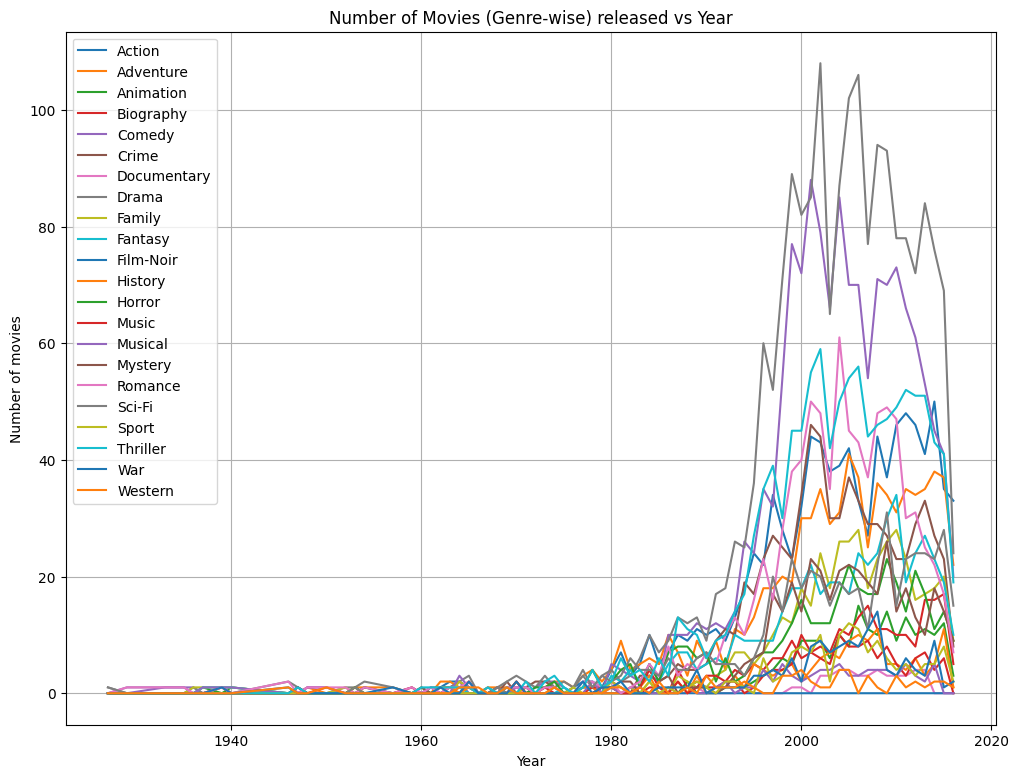

In [27]:
genre_grouped = (df[['title_year']+new_genre_columns].groupby('title_year').sum())[new_genre_columns] # GROUPING MOVIES BASED ON GENRE

plt.figure(figsize=(12, 9))
plt.plot(sorted(df['title_year'].unique()), genre_grouped, label = new_genre_columns)
plt.xlabel("Year")
plt.ylabel("Number of movies")
plt.legend()
plt.grid()
plt.title("Number of Movies (Genre-wise) released vs Year")

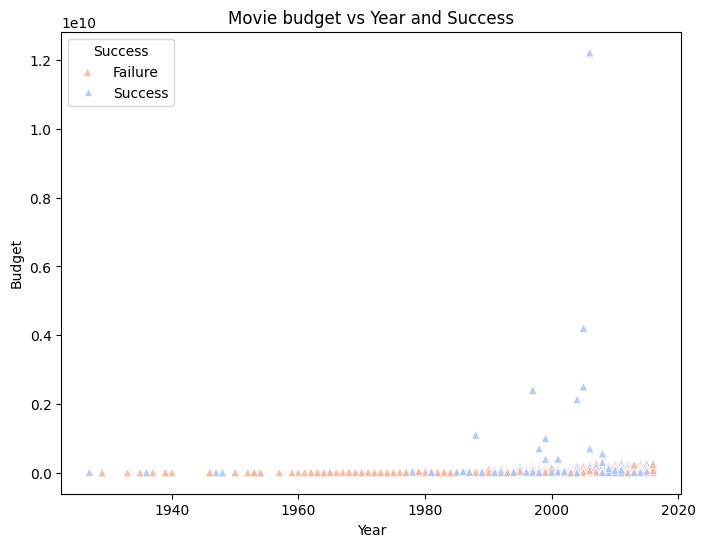

In [23]:
plt.figure(figsize=(8, 6))
# sns.scatterplot(data=df, x='movie_facebook_likes', y='success', hue='success', palette='coolwarm', alpha=0.7)
sns.scatterplot(data=df, 
                x='title_year', 
                y='budget', 
                hue='success', 
                palette='coolwarm', alpha=0.9,
                marker='^')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Budget')
plt.title('Movie budget vs Year and Success')

# Show legend
plt.legend(title='Success', 
        #    loc='upper right', 
           labels=['Failure', 'Success'])


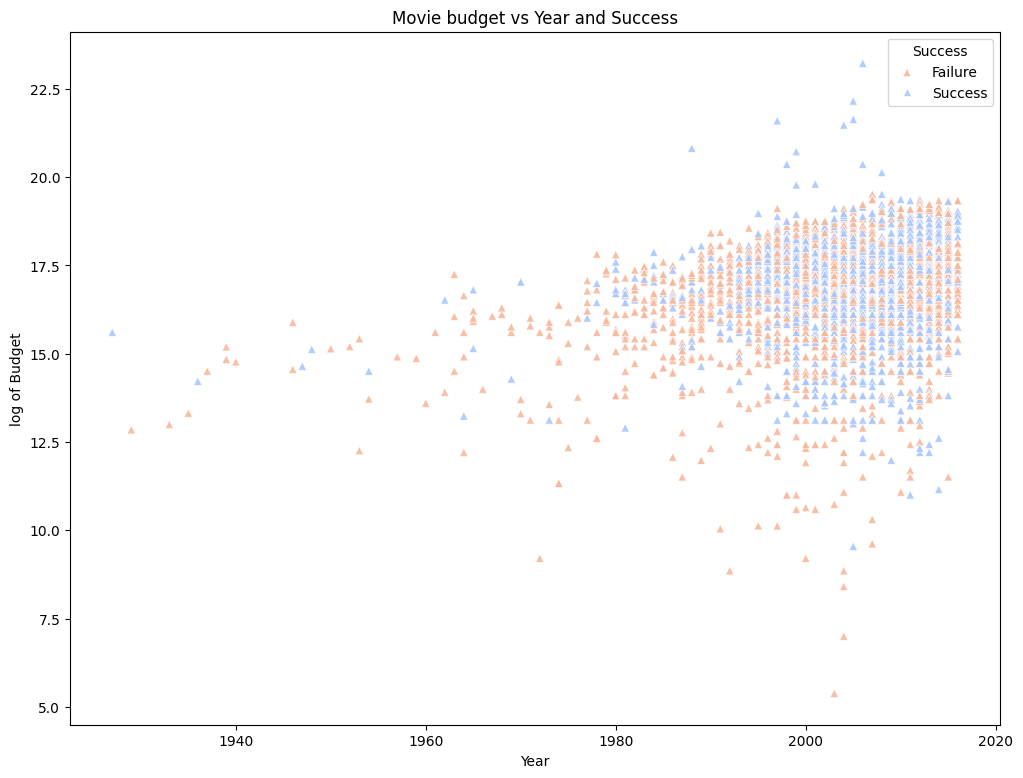

In [164]:
plt.figure(figsize=(12, 9))
# sns.scatterplot(data=df, x='movie_facebook_likes', y='success', hue='success', palette='coolwarm', alpha=0.7)
sns.scatterplot(data=df, 
                x='title_year', 
                y=np.log(df['budget']), 
                hue='success', 
                palette='coolwarm', alpha=0.9,
                marker='^')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('log of Budget')
# plt.ylabel('$\log({Budget})$')
plt.title('Movie budget vs Year and Success')

# Show legend
plt.legend(title='Success', 
        #    loc='upper right', 
           labels=['Failure', 'Success'])


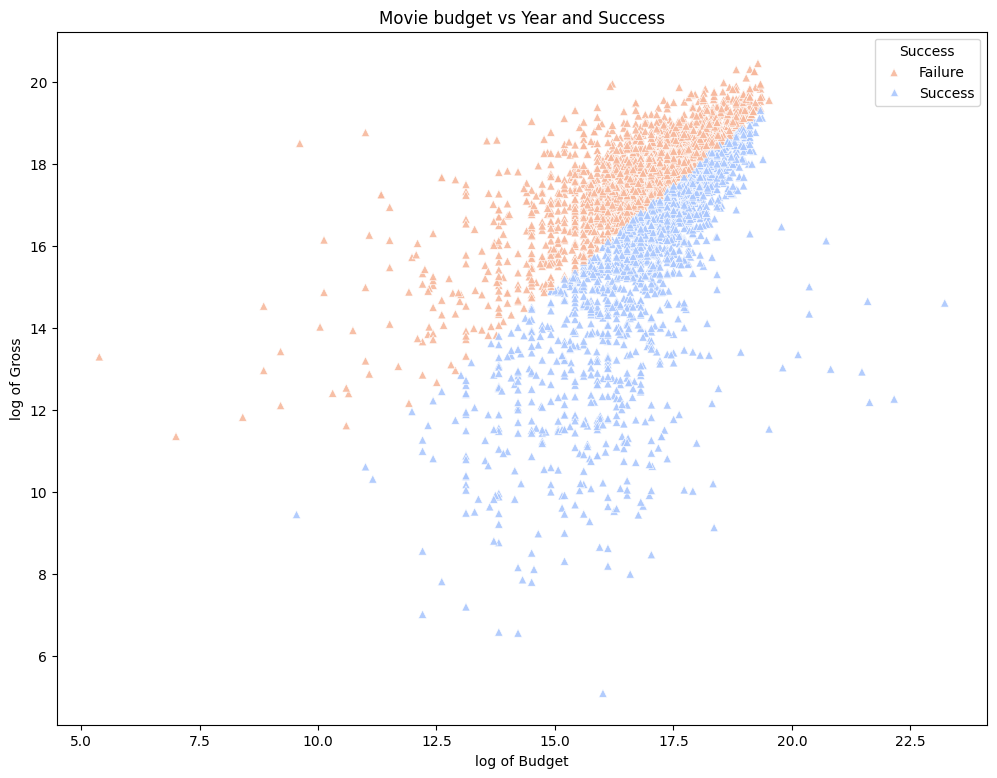

In [21]:
plt.figure(figsize=(12, 9))
# sns.scatterplot(data=df, x='movie_facebook_likes', y='success', hue='success', palette='coolwarm', alpha=0.7)
sns.scatterplot(data=df, 
                x=np.log(df['budget']), 
                y=np.log(df['gross']), 
                hue='success', 
                palette='coolwarm', alpha=0.9,
                marker='^')

# Set labels and title
plt.xlabel('log of Budget')
plt.ylabel('log of Gross')
# plt.ylabel('$\log({Budget})$')
plt.title('Movie budget vs Year and Success')

# Show legend
plt.legend(title='Success', 
        #    loc='upper right', 
           labels=['Failure', 'Success'])


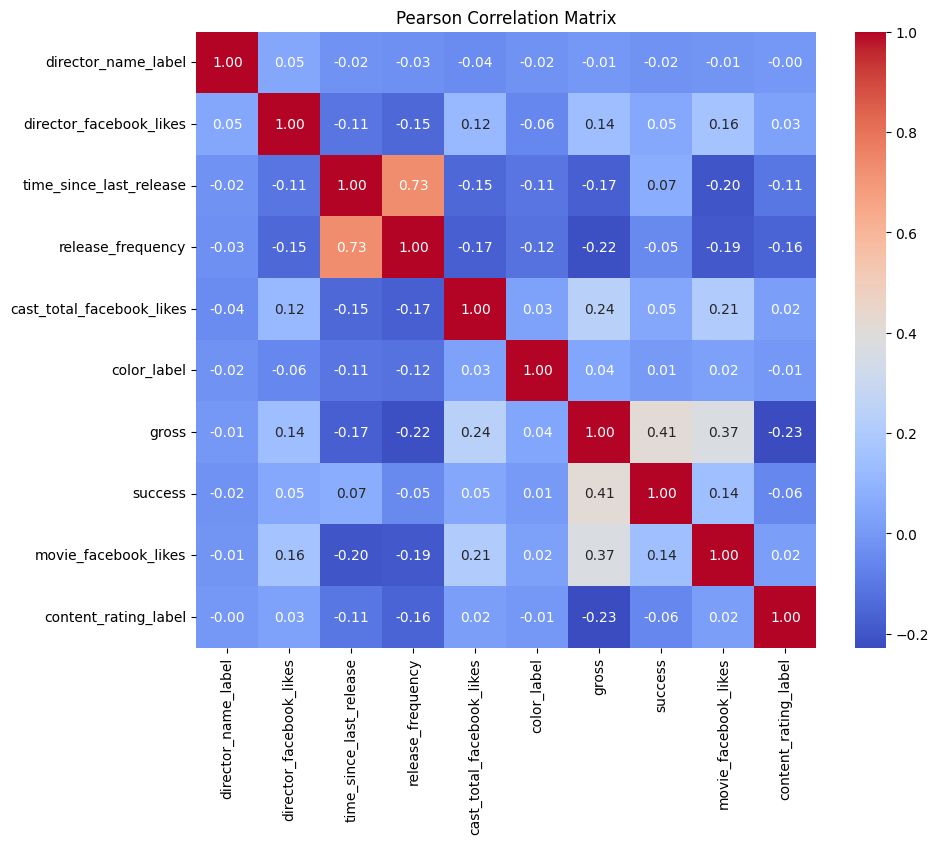

In [24]:
# PEARSON CORRELATION: 
# MEASURES THE STRENGTH AND DIRECTION OF LINEAR RELATIONSHIPS BETWEEN TWO VARIABLES. 
# A VALUE OF +1 INDICATES A PERFECT POSITIVE CORRELATION (BOTH VARIABLES INCREASE/DECREASE TOGETHER), 
#            -1 SIGNIFIES A PERFECT NEGATIVE CORRELATION (OPPOSITE MOVEMENT), AND 
#            0 SUGGESTS NO LINEAR RELATIONSHIP.

corr = data[features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

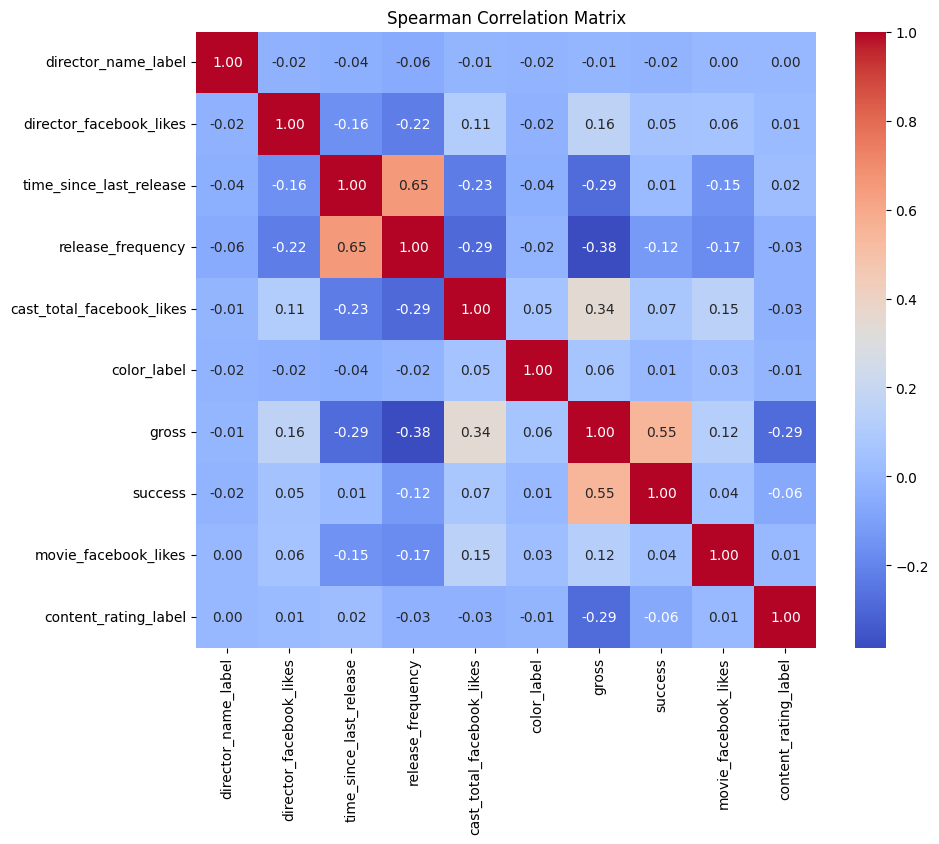

In [150]:
# SPEARMAN CORRELATION: 
# CAPTURES THE STRENGTH AND DIRECTION OF MONOTONIC RELATIONSHIPS, 
# WHERE VARIABLES TEND TO MOVE IN THE SAME OR OPPOSITE DIRECTION, 
# BUT NOT NECESSARILY AT A CONSTANT RATE. 
# IT’S LESS SENSITIVE TO OUTLIERS COMPARED TO PEARSON’S
# THE VALUE OF +1 INDICATING A PERFECT MONOTONIC RELATIONSHIP (ALWAYS INCREASING/DECREASING TOGETHER),
#              -1 SIGNIFYING A PERFECT INVERSE MONOTONIC RELATIONSHIP (ALWAYS MOVING IN OPPOSITE DIRECTIONS), AND
#               VALUES CLOSER TO 0 SUGGEST WEAKER MONOTONIC CONNECTIONS.

corr = data[features].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

In [39]:
# GROUPING MOVIES BASED ON DIRECTOR
director_movie_years = df.groupby('director_name_label')['title_year'].apply(lambda x: sorted(x.unique())).to_dict()

print("Dictionary structure:")
print(director_movie_years)


Dictionary structure:
{0: [2009.0], 1: [2006.0], 2: [1996.0], 3: [2003.0], 4: [1993.0], 5: [2004.0, 2006.0, 2008.0, 2010.0, 2013.0, 2015.0], 6: [2005.0], 7: [1999.0], 8: [2001.0, 2002.0, 2003.0, 2005.0, 2007.0, 2008.0, 2012.0], 9: [1983.0, 1986.0, 1987.0, 2002.0], 10: [2007.0], 11: [2006.0], 12: [2009.0], 13: [2011.0], 14: [1954.0], 15: [2014.0], 16: [2012.0], 17: [1998.0], 18: [1993.0, 1997.0], 19: [1994.0], 20: [1996.0, 1999.0, 2003.0], 21: [2010.0], 22: [1999.0], 23: [1996.0], 24: [2013.0, 2015.0], 25: [1999.0], 26: [1993.0, 2001.0, 2010.0], 27: [2006.0], 28: [2001.0, 2004.0, 2009.0], 29: [2000.0, 2003.0, 2006.0, 2014.0, 2015.0], 30: [2006.0, 2015.0], 31: [2016.0], 32: [2012.0], 33: [2015.0], 34: [2007.0], 35: [2006.0, 2008.0, 2011.0], 36: [1994.0, 1998.0, 2004.0, 2009.0, 2016.0], 37: [2008.0], 38: [2002.0], 39: [1998.0], 40: [1999.0, 2002.0, 2004.0, 2011.0, 2013.0], 41: [2004.0], 42: [2003.0, 2006.0, 2008.0, 2010.0], 43: [2001.0, 2004.0, 2006.0, 2013.0], 44: [1960.0], 45: [1999.0],

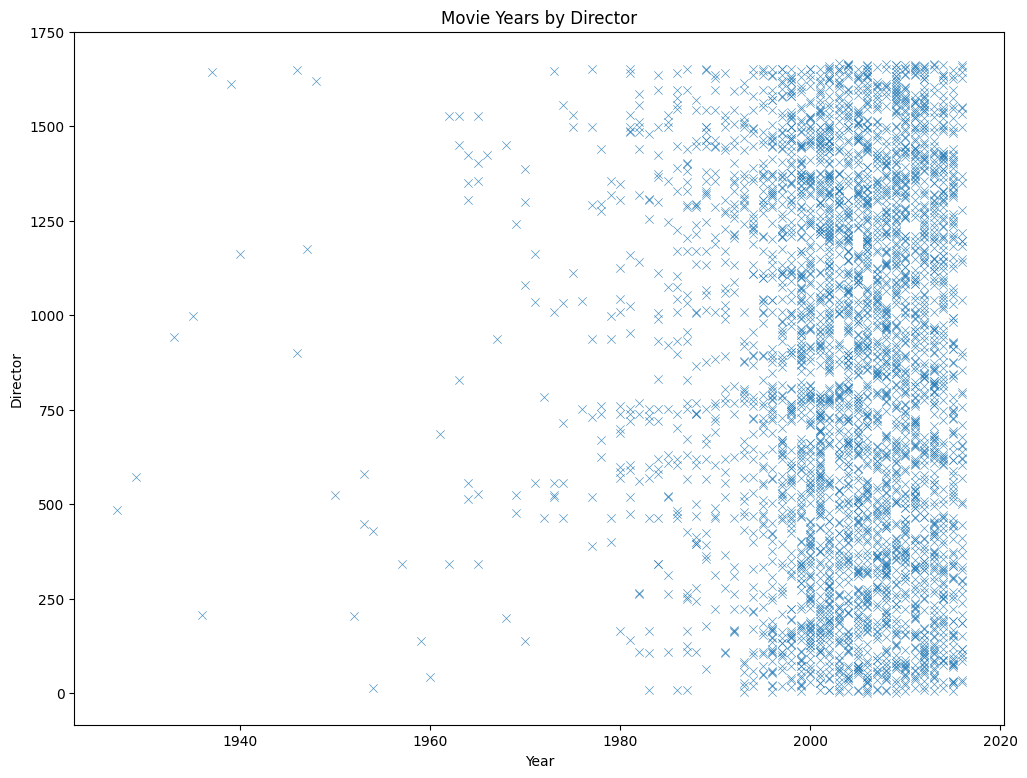

In [41]:
plot_data = pd.DataFrame([(director, year) for director, years in director_movie_years.items() for year in years], columns=['Director', 'Year'])

plt.figure(figsize=(12, 9))
sns.scatterplot(data=plot_data, x='Year', y='Director', marker='x', alpha=0.8)
plt.title('Movie Years by Director')
plt.xlabel('Year')
plt.ylabel('Director')
plt.show()

In [132]:
director_avg_year = df.groupby('director_name_label')['title_year'].mean().reset_index()


In [151]:
#
# RUN THIS CELL, AFTER FINDING A GOOD MODEL
#
director_avg_year = df.groupby('director_name_label')['title_year'].mean().reset_index()

# Make predictions for all directors
director_avg_year['predicted_movie_year'] = [round(predict_next_movie_year(director_name=_label, model=ada_model, df=df)[0])
                                              for _label in tqdm(director_avg_year['director_name_label'], desc = "Director")]


Director:   0%|          | 0/1668 [00:00<?, ?it/s]

Director: 100%|██████████| 1668/1668 [02:36<00:00, 10.68it/s]


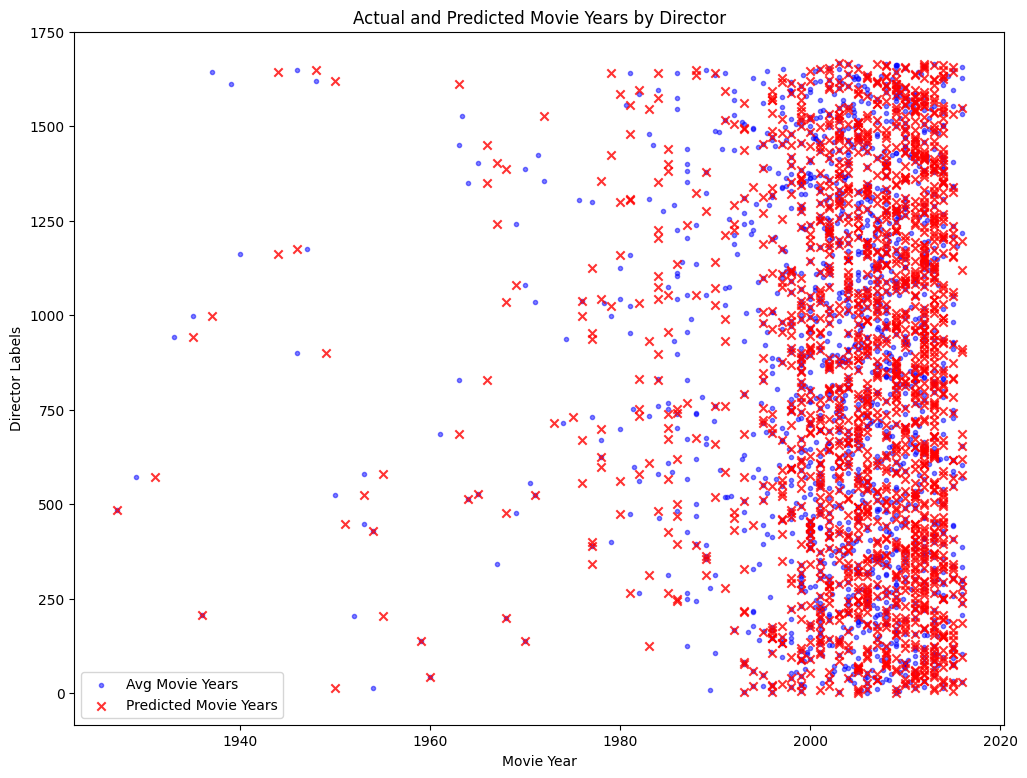

In [152]:
# Plot
plt.figure(figsize=(12, 9))
plt.scatter(director_avg_year['title_year'], director_avg_year['director_name_label'], label='Avg Movie Years', marker='.', color='blue', alpha = 0.5)
plt.scatter(director_avg_year['predicted_movie_year'], director_avg_year['director_name_label'], label='Predicted Movie Years', color='red', marker='x', alpha=0.8)
plt.xlabel('Movie Year')
plt.ylabel('Director Labels')
# plt.grid()
plt.title('Actual and Predicted Movie Years by Director')
plt.legend()
plt.show()

In [24]:
df[new_genre_columns].sum()

Action          960
Adventure       781
Animation       196
Biography       241
Comedy         1462
Crime           712
Documentary      46
Drama          1904
Family          443
Fantasy         508
Film-Noir         1
History         149
Horror          392
Music           151
Musical          96
Mystery         385
Romance         860
Sci-Fi          496
Sport           148
Thriller       1119
War             153
Western          60
dtype: int64

In [26]:
genre_dist = df[new_genre_columns].sum().sort_index()
number_of_zeros = df[new_genre_columns].shape[0] - genre_dist
number_of_ones = genre_dist

In [25]:
genre_dist.mean()

511.95454545454544

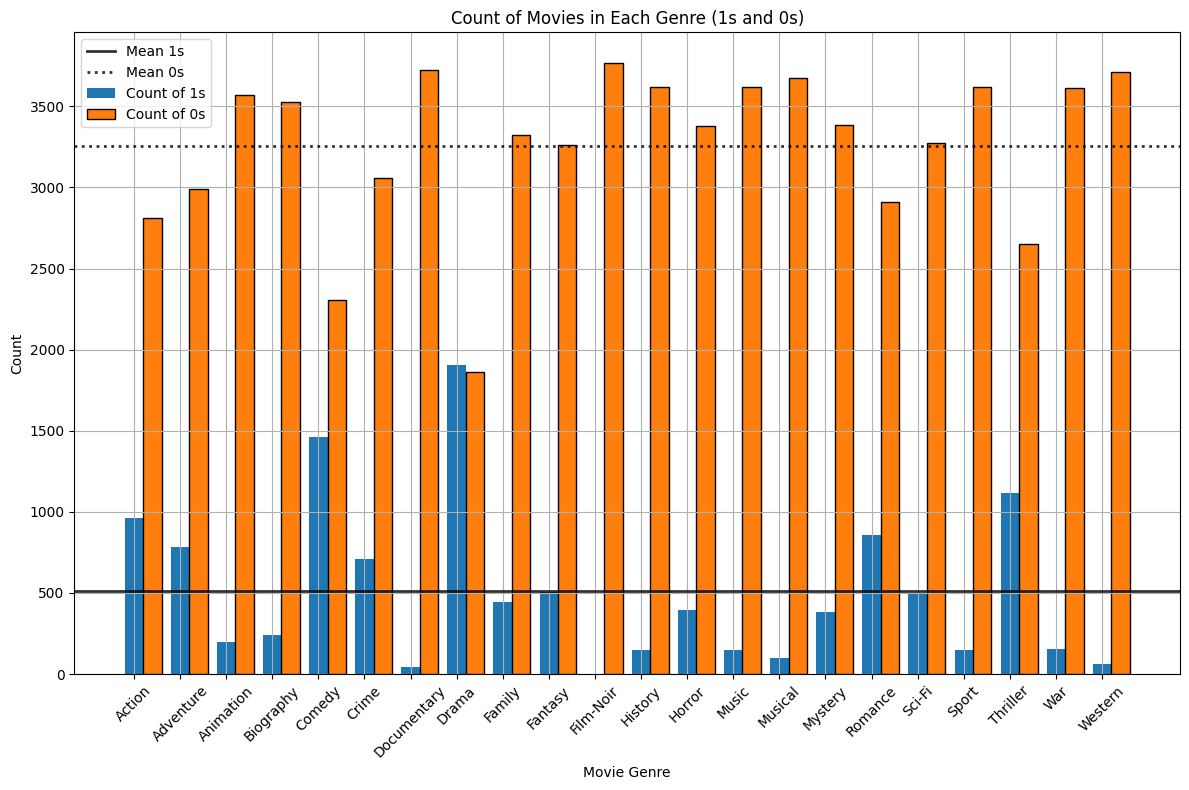

In [48]:
# Create a bar graph with two sets of bars
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
bar_width = 0.4  # Adjust bar width for better visualization

# Calculate positions for each bar set (avoiding string concatenation)
bar_positions_ones = number_of_ones.index
bar_positions_zeros = [p + bar_width for p in range(len(bar_positions_ones))]

# Plot bars for number of 1s and 0s
plt.bar(bar_positions_ones, number_of_ones.values, 
        bar_width, label='Count of 1s')
plt.bar(bar_positions_zeros, number_of_zeros.values, 
        bar_width, label='Count of 0s', edgecolor = 'black')

plt.axhline(y = genre_dist.mean(),
            color = 'black', linestyle = '-', alpha = 0.8, linewidth = 2, label = "Mean 1s")
plt.axhline(y = number_of_zeros.mean(),
            color = 'black', linestyle = ':', alpha = 0.8, linewidth = 2, label = "Mean 0s")

plt.xlabel('Movie Genre')
plt.ylabel('Count')
plt.title('Count of Movies in Each Genre (1s and 0s)')
plt.xticks(bar_positions_ones, number_of_ones.index, rotation=45, ha='center')  # Rotate x-axis labels
plt.legend()  # Add legend to differentiate bars
plt.tight_layout()
plt.grid()
plt.show()

In [31]:
df['language_label'].value_counts()
languages = processed_labels['language']
languages
# df['language_label']

{'Aboriginal': 0,
 'Arabic': 1,
 'Aramaic': 2,
 'Bosnian': 3,
 'Cantonese': 4,
 'Czech': 5,
 'Danish': 6,
 'Dari': 7,
 'Dutch': 8,
 'English': 9,
 'Filipino': 10,
 'French': 11,
 'German': 12,
 'Hebrew': 13,
 'Hindi': 14,
 'Hungarian': 15,
 'Indonesian': 16,
 'Italian': 17,
 'Japanese': 18,
 'Kazakh': 19,
 'Korean': 20,
 'Mandarin': 21,
 'Maya': 22,
 'Mongolian': 23,
 'Norwegian': 24,
 'Persian': 25,
 'Portuguese': 26,
 'Romanian': 27,
 'Russian': 28,
 'Spanish': 29,
 'Thai': 30,
 'Vietnamese': 31,
 'Zulu': 32}

In [32]:
df['language_label'].value_counts()

language_label
9     3611
11      34
29      23
21      15
12      11
18      10
17       7
4        7
26       5
14       5
20       5
24       4
8        3
25       3
30       3
6        3
0        2
7        2
16       2
5        1
10       1
31       1
15       1
32       1
27       1
2        1
22       1
1        1
13       1
3        1
19       1
23       1
28       1
Name: count, dtype: int64

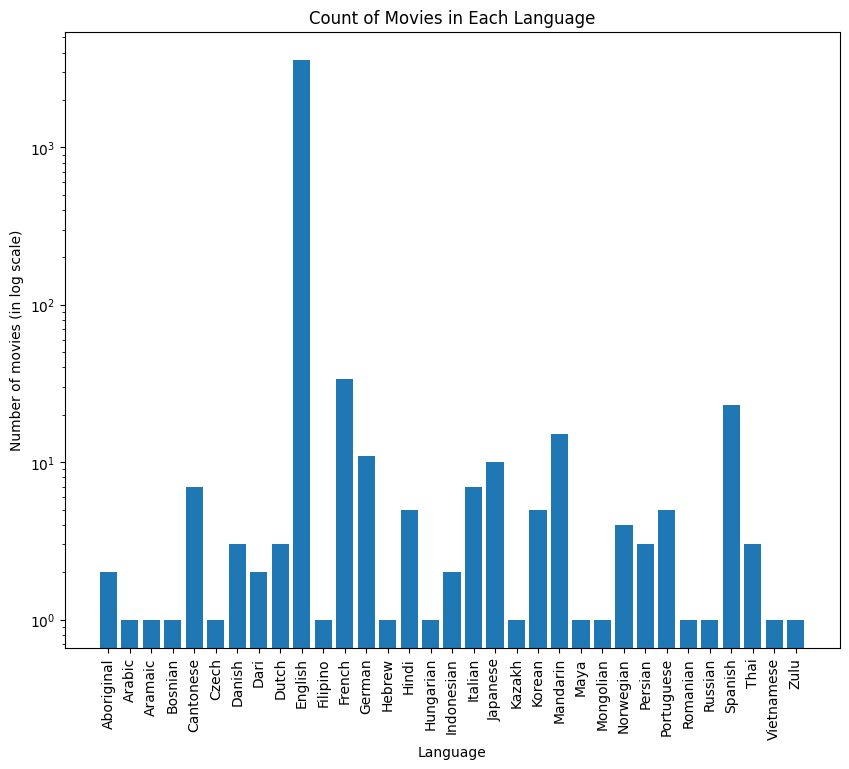

In [54]:
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
l = df['language_label'].value_counts()
# plt.bar(l.index, l.values)
plt.bar(l.index, l.values)

plt.xlabel('Language')
plt.ylabel('Number of movies (in log scale)')
plt.yscale('log')
plt.title('Count of Movies in Each Language')
plt.xticks(range(len(languages)), 
           list(languages.keys()),  rotation=90, ha='center')  # Rotate x-axis labels for better readability
# plt.tight_layout()
# plt.grid()
plt.show()

# ML

IMPORTS FOR ML


In [22]:
from sklearn.model_selection import train_test_split

# WE WILL BE TESTING THESE MODELS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor  

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [23]:

def predict_next_movie_year(director_name, model, df, verbose = False):
    # EXTRACT FEATURES FROM DATAFRAME TO PASS IN THE MODEL
    director_data = df[df['director_name_label'] == director_name]
    if director_data.empty:
        print("Director not found in the dataset.")
        return None
    current_year = datetime.now().year
    last_movie_year = director_data['title_year'].max()
    time_since_last_release = current_year - last_movie_year if not pd.isnull(last_movie_year) else 0
    director_facebook_likes = director_data['director_facebook_likes'].max()
    release_frequency = director_data['release_frequency'].max()
    
    # EXTRACT LAST MOVIE'S INFORMATION
    last_movie = director_data.iloc[-1]
    last_movie_color = last_movie['color_label']
    success = last_movie['success']
    # content_rating_label = last_movie['content_rating_label']
    content_rating_label = director_data['content_rating_label'].value_counts().max()

    # ADD OTHER FEATURES IF REQUIRED
    
    # FEATURES 
    features = {
        'director_name_label': director_name,
        'director_facebook_likes': director_facebook_likes,
        'time_since_last_release': time_since_last_release,
        'release_frequency': release_frequency,
        'cast_total_facebook_likes': last_movie['cast_total_facebook_likes'],
        'color_label': last_movie_color,
        'gross': last_movie['gross'],
        'success': success,
        'movie_facebook_likes': last_movie['movie_facebook_likes'],
        'content_rating_label': content_rating_label
    }
    if verbose:
        print("Passed features - \n", features)
    
    # PREDICT NEXT MOVIE YEAR
    # next_movie_features = [features]
    next_movie_features = [list(features.values())]

    next_movie_year = model.predict(next_movie_features)
    
    return next_movie_year


def getDirector():
    name_to_label = processed_labels["director_name"]
    names = list(name_to_label.keys())
    labels = list(map(str, name_to_label.values()))

    _d = input("Enter a Director name or Label number : ").strip()
    if _d.lower() in [i.lower() for i in name_to_label.keys()]:
        return (_d, int(name_to_label[_d]))
    elif _d in labels:
        return (names[labels.index(_d)], int(_d))
    else: 
        print(f"Check name/number. We don't have the data for :'{_d}'")
        return ("", -1)

In [24]:
def convert_labels_to_genres(predicted_labels, genre_list):
    predicted_genres = []
    for i, label in enumerate(predicted_labels):
        if label == 1:
            predicted_genres.append(genre_list[i])
    return predicted_genres

def predict_next_movie_genre(director_name, model, model_for_year, df, verbose = False):
    # EXTRACT ADDITIONAL FEATURES FORM THE DATAFRAME
    director_data = df[df['director_name_label'] == director_name]
    if director_data.empty:
        print("Director not found in the dataset.")
        return None
    current_year = datetime.now().year
    last_movie_year = director_data['title_year'].max()
    time_since_last_release = current_year - last_movie_year if not pd.isnull(last_movie_year) else 0
    director_facebook_likes = director_data['director_facebook_likes'].max()
    release_frequency = director_data['release_frequency'].max()
    
    # EXTRACT LAST MOVIE'S COLOR, SUCCESS AND CONTENT RATING LABEL
    last_movie = director_data.iloc[-1]
    last_movie_color = last_movie['color_label']
    success = last_movie['success']
    # content_rating_label = last_movie['content_rating_label']
    content_rating_label = director_data['content_rating_label'].value_counts().max()

    
    # YOU CAN EXTRACT OTHER FEATURES IF REQUIRED
    
    # MAKING A DICTIONARY TO STORE THE FEATURE FOR PASSING IN OUR MODEL
    features = {
        'director_name_label': director_name,
        'director_facebook_likes': director_facebook_likes,
        'time_since_last_release': time_since_last_release,
        'release_frequency': release_frequency,
        'cast_total_facebook_likes': last_movie['cast_total_facebook_likes'],
        'color_label': last_movie_color,
        'gross': last_movie['gross'],
        'success': success,
        'movie_facebook_likes': last_movie['movie_facebook_likes'],
        'content_rating_label': content_rating_label
    }

    # PREDICTING NEXT MOVIE USING THE PASSED MODEL
    next_movie_year = round(model_for_year.predict([list(features.values())])[0])
    features['title_year'] = next_movie_year
    if verbose:
        print("Passed features - \n", features)
    

    next_movie_features = [list(features.values())]
    next_movie_genre = model.predict(next_movie_features)
    
    return next_movie_genre[0]


### YEAR PREDICITION

SELECTING RELEVANT DATA AND SPLITTING IT FOR TRAIN AND TEST

In [25]:
# ASSIGNING FEATURES TO VAIABLES
X = data[features]
y = data[target].astype(np.int64)


In [26]:
# TRAINING-TESTING SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2525, 10) (1244, 10) (2525,) (1244,)


In [27]:
# GROUPING MOVIES BASED ON DIRECTOR
director_movie_years = df.groupby('director_name_label')['title_year'].apply(lambda x: sorted(x.unique())).to_dict()

print("Dictionary structure:")
print(director_movie_years)


Dictionary structure:
{0: [2009.0], 1: [2006.0], 2: [1996.0], 3: [2003.0], 4: [1993.0], 5: [2004.0, 2006.0, 2008.0, 2010.0, 2013.0, 2015.0], 6: [2005.0], 7: [1999.0], 8: [2001.0, 2002.0, 2003.0, 2005.0, 2007.0, 2008.0, 2012.0], 9: [1983.0, 1986.0, 1987.0, 2002.0], 10: [2007.0], 11: [2006.0], 12: [2009.0], 13: [2011.0], 14: [1954.0], 15: [2014.0], 16: [2012.0], 17: [1998.0], 18: [1993.0, 1997.0], 19: [1994.0], 20: [1996.0, 1999.0, 2003.0], 21: [2010.0], 22: [1999.0], 23: [1996.0], 24: [2013.0, 2015.0], 25: [1999.0], 26: [1993.0, 2001.0, 2010.0], 27: [2006.0], 28: [2001.0, 2004.0, 2009.0], 29: [2000.0, 2003.0, 2006.0, 2014.0, 2015.0], 30: [2006.0, 2015.0], 31: [2016.0], 32: [2012.0], 33: [2015.0], 34: [2007.0], 35: [2006.0, 2008.0, 2011.0], 36: [1994.0, 1998.0, 2004.0, 2009.0, 2016.0], 37: [2008.0], 38: [2002.0], 39: [1998.0], 40: [1999.0, 2002.0, 2004.0, 2011.0, 2013.0], 41: [2004.0], 42: [2003.0, 2006.0, 2008.0, 2010.0], 43: [2001.0, 2004.0, 2006.0, 2013.0], 44: [1960.0], 45: [1999.0],

                                
PARAMETERS WERE TUNED TO GET LOW ERROR

RANDOM FOREST REGRESSOR

In [156]:
# -------------- GOT ------------------
# Mean Squared Error: 25.423684218213072
# Mean Absolute Error: 3.0967182202039165
# R-squared: 0.7505793907814517

# Initialize and train the model
rf_model = RandomForestRegressor( 
                                max_depth=350, 
                                n_jobs=8,
                                # max_features='sqrt',
                                max_features="log2",
                                max_leaf_nodes=350, 
                                n_estimators=250,
                                criterion='poisson',
                                # criterion='absolute_error',
                                # criterion='friedman_mse'
                              ) 

rf_model.fit(X_train.values, y_train.values)
# Make predictions on the test set
y_pred = rf_model.predict(X_test.values)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 25.774970944848963
Mean Absolute Error: 3.1020062790356975
R-squared: 0.7471330708611805


In [141]:
# director_name = 'Chris Columbus' OR 222
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, rf_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2011
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


GRADIENT BOOSTING REGRESSOR

In [144]:
# ------------- GOT --------------------
# Mean Squared Error: 21.695774451175176
# Mean Absolute Error: 2.8521368925725143
# R-squared: 0.7871522775914707

# Initialize and train the model
gbr_model = GradientBoostingRegressor(  
                                    n_estimators=1500, 
                                    learning_rate=0.03, 
                                    max_depth=7,
                                    # max_features='sqrt',
                                    max_features = 'log2',
                                    max_leaf_nodes=30,
                                  )
gbr_model.fit(X_train.values, y_train.values)
# Make predictions on the test set
y_pred = gbr_model.predict(X_test.values)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 22.05739935548014
Mean Absolute Error: 2.865258295473857
R-squared: 0.7836045343467788


In [145]:
# director_name = 'Chris Columbus' OR 222
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, gbr_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2013
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


SUPPORT VECTOR REGRESSOR

In [146]:
# ------------- GOT ------------------
# Mean Squared Error: 103.51094149694111
# Mean Absolute Error: 7.0811976674348065
# R-squared: -0.015500423438125077

# svr_model = SVR(kernel='linear', max_iter=10000) 
# svr_model = SVR(kernel='poly')
svr_model = SVR(kernel='rbf')

svr_model.fit(X_train.values, y_train.values)
# Make predictions on the test set
y_pred = svr_model.predict(X_test.values)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)


Mean Squared Error: 103.51094149694111
Mean Absolute Error: 7.0811976674348065
R-squared: -0.015500423438125077


In [147]:
# director_name = 'Chris Columbus' OR 222
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, svr_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2005
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


ADA-BOOST REGRESSOR

In [104]:
# --------------- GOT --------------------
# Mean Squared Error: 21.713337026937033
# Mean Absolute Error: 2.855243113162392
# R-squared: 0.7869799788676362

reg_1 = GradientBoostingRegressor(  
                                    n_estimators=2000, 
                                    learning_rate=0.03, 
                                    max_depth=7,
                                    # max_features='sqrt',
                                    max_features = 'log2',
                                    max_leaf_nodes=30,
                                  )

rng = np.random.RandomState(1)
ada_model = AdaBoostRegressor(
                            reg_1, 
                            n_estimators=50, 
                            random_state=rng,
                            learning_rate= 0.03,
                            # loss='square',
                            loss = 'exponential',
                            )

# model = reg_1
ada_model.fit(X_train.values, y_train.values)
# Make predictions on the test set
y_pred = ada_model.predict(X_test.values)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 21.713337026937033
Mean Absolute Error: 2.855243113162392
R-squared: 0.7869799788676362


In [105]:
# director_name = 'Chris Columbus' OR 222
director_name, director_label = [i for i in [getDirector()] if len(i[0]) > 0][0]
predicted_year = predict_next_movie_year(director_label, ada_model, df)
print(f"Predicted next movie year for {director_name} : {round(predicted_year[0])}")

print(f"historical data : {director_movie_years[director_label]}")

Predicted next movie year for Chris Columbus : 2012
historical data : [1990.0, 1992.0, 1993.0, 1998.0, 1999.0, 2001.0, 2002.0, 2005.0, 2009.0, 2010.0, 2015.0]


### PREDICTING GENRE

In [157]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import precision_score, recall_score, f1_score


In [30]:
# SELECTING FEATURES 
target = new_genre_columns

data_with_genre = df[features + new_genre_columns + ['title_year']].copy()

In [31]:
data_with_genre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3769 entries, 3497 to 3678
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   director_name_label        3769 non-null   int64  
 1   director_facebook_likes    3769 non-null   float64
 2   time_since_last_release    3769 non-null   float64
 3   release_frequency          3769 non-null   float64
 4   cast_total_facebook_likes  3769 non-null   int64  
 5   color_label                3769 non-null   int64  
 6   gross                      3769 non-null   float64
 7   success                    3769 non-null   int32  
 8   movie_facebook_likes       3769 non-null   int64  
 9   content_rating_label       3769 non-null   int64  
 10  Action                     3769 non-null   int64  
 11  Adventure                  3769 non-null   int64  
 12  Animation                  3769 non-null   int64  
 13  Biography                  3769 non-null   int64  

In [32]:
# ASSIGNING FEATURES TO VARIABLES 
X_genre = data_with_genre[features + ['title_year']]
y_genre = data_with_genre[target]

In [33]:
# TRAING AND TESTING DATA SPLITTING
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(X_genre, y_genre, test_size=0.3, random_state=42)

print(X_train_genre.shape, X_test_genre.shape, y_train_genre.shape, y_test_genre.shape)


(2638, 11) (1131, 11) (2638, 22) (1131, 22)


MULTI-LABEL CLASSIFIER MODEL WITH MultiOutputClassifier

- BASE = RANDOM FOREST CLASSIFIER

In [102]:
# ---------- GOT -----------
# Model Accuracy: 0.08134394341290893
# Precision: 0.6340677610640195
# Recall: 0.31117021276595747
# F1 Score: 0.3698335451226795

rng = np.random.RandomState(0)
inner = RandomForestClassifier(n_estimators=400, 
                               max_depth=20, 
                               random_state=rng)

rf_multi_model = MultiOutputClassifier(inner,
                                        n_jobs=8)
rf_multi_model.fit(X_train_genre, y_train_genre)

# Predict labels for the test set
y_pred_genre = rf_multi_model.predict(X_test_genre)
# Evaluate the model
accuracy = rf_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_genre, y_pred_genre, average='weighted')
recall = recall_score(y_test_genre.values, y_pred_genre, average='weighted')
f1 = f1_score(y_test_genre.values, y_pred_genre, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Accuracy: 0.08134394341290893
Precision: 0.6340677610640195
Recall: 0.31117021276595747
F1 Score: 0.3698335451226795


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
director_name = 222
predicted_genres = convert_labels_to_genres(predict_next_movie_genre(director_name, 
                                                                     rf_multi_model, 
                                                                     model_for_year= ada_model,
                                                                     df = df, verbose = 1), 
                                            new_genre_columns)
print("Predicted Genres for the Next Movie(s):", predicted_genres)

Passed features - 
 {'director_name_label': 222, 'director_facebook_likes': 0.0, 'time_since_last_release': 9.0, 'release_frequency': 5.363636363636363, 'cast_total_facebook_likes': 35367, 'color_label': 1, 'gross': 78747585.0, 'success': 0, 'movie_facebook_likes': 39000, 'content_rating_label': 6, 'title_year': 2012}
Predicted Genres for the Next Movie(s): ['Adventure', 'Family', 'Fantasy']


- BASE = ADA-BOOST CLASSIFIER

In [154]:
# ------------ GOT --------------
# Model Accuracy: 0.05658709106984969
# Precision: 0.5197214996385213
# Recall: 0.3191489361702128
# F1 Score: 0.36803802340660957

rng = np.random.RandomState(0)

inner = AdaBoostClassifier(n_estimators=300, 
                           learning_rate=0.7,
                           random_state=rng)

# Train a multi-label classification model
ada_multi_model = MultiOutputClassifier(inner, 
                                        n_jobs=8)
ada_multi_model.fit(X_train_genre.values, y_train_genre.values)

# Predict labels for the test set
y_pred_genre = ada_multi_model.predict(X_test_genre.values)

# Evaluate the model
accuracy = ada_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_genre, y_pred_genre, average='weighted')
recall = recall_score(y_test_genre, y_pred_genre, average='weighted')
f1 = f1_score(y_test_genre, y_pred_genre, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Accuracy: 0.05658709106984969
Precision: 0.5197214996385213
Recall: 0.3191489361702128
F1 Score: 0.36803802340660957


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
director_name = 222
predicted_genres = convert_labels_to_genres(predict_next_movie_genre(director_name, 
                                                                     ada_multi_model, 
                                                                     model_for_year= ada_model,
                                                                     df = df, verbose = 1),
                                            new_genre_columns)
print("Predicted Genres for the Next Movie(s):", predicted_genres)

Passed features - 
 {'director_name_label': 222, 'director_facebook_likes': 0.0, 'time_since_last_release': 9.0, 'release_frequency': 5.363636363636363, 'cast_total_facebook_likes': 35367, 'color_label': 1, 'gross': 78747585.0, 'success': 0, 'movie_facebook_likes': 39000, 'content_rating_label': 6, 'title_year': 2012}
Predicted Genres for the Next Movie(s): ['Adventure', 'Family', 'Sci-Fi']


In [195]:
# ------------- GOT ----------------
# Model Accuracy: 0.09902740937223696
# Precision: 0.5552560675725418
# Recall: 0.4021867612293144
# F1 Score: 0.44908631002658567

rng = np.random.RandomState(0)

inner = XGBClassifier(n_estimators=1000, 
                      max_depth=6, 
                      learning_rate=0.2, 
                      random_state=rng)

# Wrap XGBClassifier with MultiOutputClassifier
xgb_multi_model = MultiOutputClassifier(inner,
                                        n_jobs=8)

# Train the model
xgb_multi_model.fit(X_train_genre.values, y_train_genre.values)

# Predict labels for the test set
y_pred_genre = xgb_multi_model.predict(X_test_genre.values)

# Evaluate the model
accuracy = xgb_multi_model.score(X_test_genre, y_test_genre)
print("Model Accuracy:", accuracy)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test_genre, y_pred_genre, average='weighted')
recall = recall_score(y_test_genre, y_pred_genre, average='weighted')
f1 = f1_score(y_test_genre, y_pred_genre, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Model Accuracy: 0.09902740937223696
Precision: 0.5552560675725418
Recall: 0.4021867612293144
F1 Score: 0.44908631002658567


e:\Downloads\WeLearn\9th Sem\nineSemEnv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [191]:
director_name = 222
predicted_genres = convert_labels_to_genres(predict_next_movie_genre(director_name, 
                                                                     xgb_multi_model, 
                                                                     model_for_year= ada_model,
                                                                     df = df, verbose = 1),
                                            new_genre_columns)
print("Predicted Genres for the Next Movie(s):", predicted_genres)

Passed features - 
 {'director_name_label': 222, 'director_facebook_likes': 0.0, 'time_since_last_release': 9.0, 'release_frequency': 5.363636363636363, 'cast_total_facebook_likes': 35367, 'color_label': 1, 'gross': 78747585.0, 'success': 0, 'movie_facebook_likes': 39000, 'content_rating_label': 6, 'title_year': 2012}
Predicted Genres for the Next Movie(s): ['Adventure', 'Family', 'Fantasy']


In [128]:
_director_data = df[df['director_name_label'] == 222]
_director_data[['title_year', 'title_year_DateStamp', 'time_since_last_release', 'genres']]

,title_year,title_year_DateStamp,time_since_last_release,genres
2601,1990.0,1990-01-01,34.0,Comedy|Family
2153,1992.0,1992-01-01,2.0,Adventure|Comedy|Family
1867,1993.0,1993-01-01,1.0,Comedy|Drama|Family|Romance
943,1998.0,1998-01-01,5.0,Comedy|Drama
385,1999.0,1999-01-01,1.0,Comedy|Drama|Sci-Fi
202,2001.0,2001-01-01,2.0,Adventure|Family|Fantasy
285,2002.0,2002-01-01,1.0,Adventure|Family|Fantasy|Mystery
1273,2005.0,2005-01-01,3.0,Drama|Musical|Romance
2436,2009.0,2009-01-01,4.0,Comedy|Romance
351,2010.0,2010-01-01,1.0,Adventure|Family|Fantasy


# RESULTS


### For Sub-Task 1

| Model | Mean Squared Error | Mean Absolute Error | R-squared |
|-|-|-|-|
| Random Forest Regressor | 25.42 | 3.10 | 0.75 |
| Gradient Boosting Regressor | 22.06 | 2.87 | 0.78 |
| Support Vector Regressor | 103.51 | 7.08 | -0.02 |
| **AdaBoost Regressor** | **21.71** | **2.86** | **0.79** |

### For Sub-Task 2

| Model | Model Accuracy | Precision | Recall | F1 Score |
|-|-|-|-|-|
| Random Forest Classifier | 0.0813 | 0.6341 | 0.3112 | 0.3698 |
| AdaBoost Classifier | 0.0566 | 0.5197 | 0.3191 | 0.3680 |
| **XGBoost Classifier** | **0.09903** | **0.5552** | **0.4022** | **0.4490** | 